In [3]:
import os 

In [5]:
# ! pip install keras

### Load image 

In [47]:
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed
import numpy as np 
import pandas as pd 

def load_images(path, size=(256,512)):
    src_list = list()
    tar_list = list()
    for filename in listdir(path):
        # load and resize the image
        pixels = load_img(path + filename, target_size=size) # images are in PIL formate
        # convert to numpy array
        pixels = img_to_array(pixels)
        # split into colored and sketch. 256 comes from 512/2. The first part is colored while the rest is sketch
        color_img, bw_img = pixels[:, :256], pixels[:, 256:]
        src_list.append(bw_img)
        tar_list.append(color_img)
        
    return [asarray(src_list), asarray(tar_list)]

### Process the training dataset 

In [15]:
path = "/Users/meierhabarexiti/Documents/gaas/data/prod/anime-sketch-colorization-pair/data/train/"
# load dataset
[src_images, tar_images] = load_images(path)
print('Loaded: ', src_images.shape, tar_images.shape)
# save as compressed numpy array
filename = 'gan_img_train.npz'
savez_compressed(filename, src_images, tar_images)
print('Saved dataset: ', filename)

Loaded:  (14224, 256, 256, 3) (14224, 256, 256, 3)
Saved dataset:  gan_img_train.npz


In [21]:
# pixels = load_img(path + '1340005.png', target_size=(256,512)) # 2 images: left colored,right bw
# pixels
# pixels = img_to_array(pixels)

In [38]:
os.listdir()

['tests.ipynb',
 'gan_img_train.npz',
 '.ipynb_checkpoints',
 'Build a Pix2Pix GAN With Python.ipynb']

Loaded:  (14224, 256, 256, 3) (14224, 256, 256, 3)


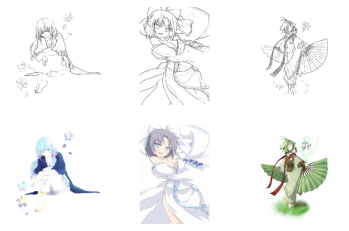

In [39]:
# check data in the zip file 
from numpy import load
from matplotlib import pyplot

# load the dataset
data = load(filename)
src_images, tar_images = data['arr_0'], data['arr_1']
print('Loaded: ', src_images.shape, tar_images.shape)

# plot source images
n_samples = 3
for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(src_images[i].astype('uint8'))

# plot target image
for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + n_samples + i)
    pyplot.axis('off')
    pyplot.imshow(tar_images[i].astype('uint8'))
  
pyplot.show()

# pyplot.imshow(src_images[1].astype('uint8'))

### Build the network 
#### 1. Define discriminator

In [117]:
import tensorflow.keras as tk
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Input
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

In [118]:
def define_discriminator(image_shape):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # source image input
    in_src_image = tk.Input(shape=image_shape)
    # target image input
    in_target_image = tk.Input(shape=image_shape)

    # concatenate images channel-wise
    merged = Concatenate()([in_src_image, in_target_image])
    # C64
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    # C128
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C256
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C512
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # second last output layer
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # patch output
    d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
    # define model
    model = Model([in_src_image, in_target_image], patch_out)

    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])

    return model

In [87]:
image_shape = (64,)
x = tk.Input(shape=image_shape)
y = tk.Input(shape=image_shape)
t = Concatenate()([x,y])
print(t)

KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='concatenate_3/concat:0', description="created by layer 'concatenate_3'")


#### 2. Define Generator
Generator contains combines a decoder and an encoder (Its a U-Net structure here). The encoder tries to break the input image down into smaller pieces. From these pieces, the decoder later tries to scale it up and generate a new image in the end.

In [ ]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add downsampling layer
    g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g
 
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add upsampling layer
    g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # add batch normalization
    g = BatchNormalization()(g, training=True)
    # conditionally add dropout
    if dropout:
        g = Dropout(0.5)(g, training=True)
    # merge with skip connection
    g = Concatenate()([g, skip_in])
    # relu activation
    g = Activation('relu')(g)
    return g
 
def define_generator(image_shape=(256,256,3)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=image_shape)

    # encoder model
    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    e7 = define_encoder_block(e6, 512)
  
    # bottleneck, no batch norm and relu
    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
    b = Activation('relu')(b)

    # decoder model
    d1 = decoder_block(b, e7, 512)
    d2 = decoder_block(d1, e6, 512)
    d3 = decoder_block(d2, e5, 512)
    d4 = decoder_block(d3, e4, 512, dropout=False)
    d5 = decoder_block(d4, e3, 256, dropout=False)
    d6 = decoder_block(d5, e2, 128, dropout=False)
    d7 = decoder_block(d6, e1, 64, dropout=False)

    # output
    g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
    out_image = Activation('tanh')(g)

    # define model
    model = Model(in_image, out_image)

    return model

#### 3. Define GAN
Putting discriminator and generator together, now we have our GAN. An interesting note here is that, we have to set discriminator as “not trainable”. Because if it is trainable, the generator will adjust discriminator’s weights and make it easier to fool it 

In [119]:
def define_gan(g_model, d_model, image_shape):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # define the source image
    in_src = Input(shape=image_shape)
    # connect the source image to the generator input
    gen_out = g_model(in_src)
    # connect the source input and generator output to the discriminator input
    dis_out = d_model([in_src, gen_out])
    # src image as input, generated image and classification output
    model = Model(in_src, [dis_out, gen_out])
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])

    return model

#### 4. Train the network
##### 4.1 Load and process image 

In [123]:
def load_real_samples(filename):
    # load compressed arrays
    data = load(filename)
    # unpack arrays. arr_0 is source array, while arr_1 is target array
    X1, X2 = data['arr_0'], data['arr_1']

    # scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]


##### 4.2 Get real and fake images 
To train the discriminator, we need a lot of real and fake images. In the following functions, generate_real_samples will give us some random samples with its expected transformed result. On the other hand, generate_fake_samples utilizes our generator network to create fake images based on its input. We label the expected result as 1, and 0 for those predicted by the generator to show discriminator that these images are fake.

In [124]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
    # unpack dataset (source, target)
    trainA, trainB = dataset
    # choose random instances
    ix = randint(0, trainA.shape[0], n_samples)
    # retrieve selected images
    X1, X2 = trainA[ix], trainB[ix]
    # generate 'real' class labels (1)
    y = np.ones((n_samples, patch_shape, patch_shape, 1))

    return [X1, X2], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
    # generate fake instance
    X = g_model.predict(samples)
    # create 'fake' class labels (0)
    y = np.zeros((len(X), patch_shape, patch_shape, 1))

    return X, y

127.5

##### 4.3 Function to track trainig process
It’s always helpful to know how our network performs during the training process. So here we write a function that saves the model’s weight into a h5 file. It also creates a plot comparing the real input, output and the generated image:

In [ ]:
def summarize_performance(step, g_model, dataset, n_samples=3):
    # select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    # generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)

    # scale all pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0

    # plot real source images
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X_realA[i])

    # plot generated target image
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples + i)
        pyplot.axis('off')
        pyplot.imshow(X_fakeB[i])

    # plot real target image
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
        pyplot.axis('off')
        pyplot.imshow(X_realB[i])

    # save plot to file
    plot_name = 'plot_%06d.png' % (step+1)
    pyplot.savefig(plot_name)
    pyplot.close()

    # save the generator model
    model_name = 'model_%06d.h5' % (step+1)
    g_model.save(model_name)
    print('>Saved: %s and %s' % (plot_name, model_name))

To be continues...